#### Import libraries

In [1]:
import io
import zipfile
import requests
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Download data programatically

In [74]:
url =  'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2017.zip'
path="./" + url.split("/")[-1].split(".")[0]
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=path)

#### Read in the files

In [2]:
working_dir = os.getcwd()

public_file = []

for root, dirs, files in os.walk(working_dir):
    files = glob.glob(os.path.join(root, '*public.csv'))
    for f in files:
        public_file.append(f)

schema_file = []

for root, dirs, files in os.walk(working_dir):
    files = glob.glob(os.path.join(root, '*schema.csv'))
    for f in files:
        schema_file.append(f)

In [3]:
pd.options.display.max_colwidth = None # Changing default dataframe column width so we can see the entire Question column

In [4]:
schema = pd.read_csv(schema_file[0])
schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to open source projects?
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree-granting college or university program?"


In [5]:
pd.options.display.max_columns = None # Changing the default dataframe columns shown so that we can see al of them

In [6]:
survey = pd.read_csv(public_file[0])
survey.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stack Overflow,9.0,Deskto

In [26]:
#pd.options.display.max_rows = 10

In [14]:
schema[schema.Column == 'JobSatisfaction']

,Column,Question
19,JobSatisfaction,Job satisfaction rating


#### Question 1 - At what types of companies do developers get paid the most?

C:\Users\moche\AppData\Local\Temp\ipykernel_49428\1666348782.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


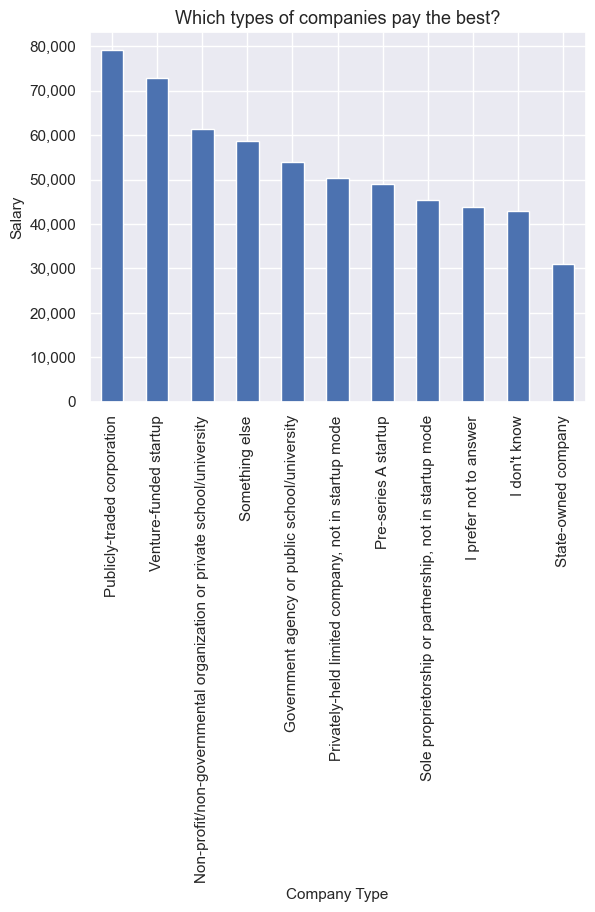

In [16]:
sns.set_theme()

survey.groupby('CompanyType').mean()['Salary'].sort_values(ascending=False).plot(kind='bar')
plt.title('Which types of companies pay the best?', fontsize=13)
plt.ylabel('Salary', fontsize=11)
plt.yticks(fontsize = 11)
plt.xlabel('Company Type', fontsize=11)
plt.xticks(fontsize = 11)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

#### Question 2 - How does programming experience affect pay at different types of companies?

In [17]:
heatmap_df = survey.groupby(['YearsProgram','CompanyType']).mean().Salary.unstack()

In [18]:
heatmap_df.reset_index().YearsProgram.str.split(',').explode().tolist()

['1 to 2 years',
 '10 to 11 years',
 '11 to 12 years',
 '12 to 13 years',
 '13 to 14 years',
 '14 to 15 years',
 '15 to 16 years',
 '16 to 17 years',
 '17 to 18 years',
 '18 to 19 years',
 '19 to 20 years',
 '2 to 3 years',
 '20 or more years',
 '3 to 4 years',
 '4 to 5 years',
 '5 to 6 years',
 '6 to 7 years',
 '7 to 8 years',
 '8 to 9 years',
 '9 to 10 years',
 'Less than a year']

In [19]:
heatmap_df.columns

Index(['Government agency or public school/university', 'I don't know',
       'I prefer not to answer',
       'Non-profit/non-governmental organization or private school/university',
       'Pre-series A startup',
       'Privately-held limited company, not in startup mode',
       'Publicly-traded corporation',
       'Sole proprietorship or partnership, not in startup mode',
       'Something else', 'State-owned company', 'Venture-funded startup'],
      dtype='object', name='CompanyType')

In [20]:
reordercolumnslist = [
    'Publicly-traded corporation',
    'Venture-funded startup',
    'Non-profit/non-governmental organization or private school/university',
    'Something else',
    'Government agency or public school/university',
    'Privately-held limited company, not in startup mode',
      'Pre-series A startup',
     'Sole proprietorship or partnership, not in startup mode',
    "I don't know",
    'I prefer not to answer',
    'State-owned company',
]

In [21]:
reorderindexlist = [
    'Less than a year',
    '1 to 2 years',
    '2 to 3 years',
    '3 to 4 years',
    '4 to 5 years',
    '5 to 6 years',
    '6 to 7 years',
    '7 to 8 years',
    '8 to 9 years',
    '9 to 10 years',
    '10 to 11 years',
    '11 to 12 years',
    '12 to 13 years',
    '13 to 14 years',
    '14 to 15 years',
    '15 to 16 years',
    '16 to 17 years',
    '17 to 18 years',
    '18 to 19 years',
    '19 to 20 years',
    '20 or more years'
]

In [22]:
heatmap_df = heatmap_df.reindex(reorderindexlist)

In [23]:
heatmap_df.columns = reordercolumnslist

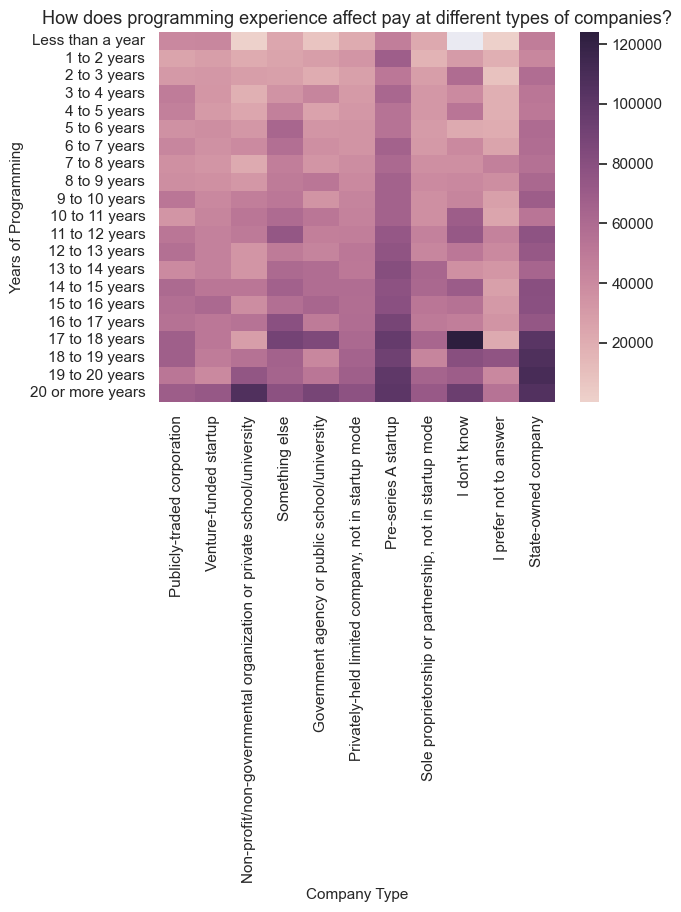

In [24]:
sns.heatmap(heatmap_df, cmap=sns.cubehelix_palette(as_cmap=True))
plt.ylabel('Years of Programming', fontsize=11)
plt.xlabel('Company Type', fontsize=11)
plt.title('How does programming experience affect pay at different types of companies?', fontsize=13);

#### Question 3 - Does the ability to work remotely impact job satisfaction and salary?

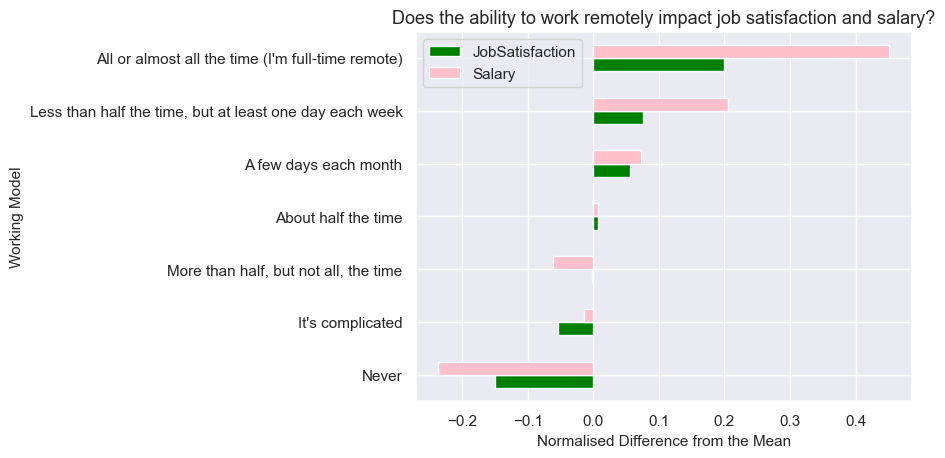

In [32]:
avg_job_sat = survey.JobSatisfaction.mean()
std_job_sat = survey.JobSatisfaction.std()

avg_sal = survey.Salary.mean()
std_sal = survey.Salary.std()

sat_sal_df = survey.groupby('HomeRemote').mean()[['JobSatisfaction','Salary']]
sat_sal_df.columns = ['AvgJobSatisfaction', 'AvgSalary']

sat_sal_df['JobSatisfaction'] = (sat_sal_df.AvgJobSatisfaction - avg_job_sat) / std_job_sat
sat_sal_df['Salary'] = (sat_sal_df.AvgSalary - avg_sal) / std_sal

ax = sat_sal_df.sort_values('JobSatisfaction', ascending=True)[['JobSatisfaction', 'Salary']].plot.barh(color = ['green', 'pink'])
plt.title('Does the ability to work remotely impact job satisfaction and salary?', fontsize=13)
plt.ylabel('Working Model', fontsize=11)
plt.yticks(fontsize = 11)
plt.xlabel('Normalised Difference from the Mean', fontsize=11)
plt.xticks(fontsize = 11);